**Overview**



This project focuses on addressing the challenging task of visual grounding, which involves associating textual descriptions with specific regions or objects in images. To accomplish this, we employ a fine-tuning approach using the CLIP (Contrastive Language-Image Pretraining) model on the RefCOCOg dataset. By fine-tuning CLIP and creating a customized model, we aim to develop a powerful and accurate solution for visual grounding, enabling machines to effectively understand and interpret the relationship between language and visual content.

# Fine-tune CLIP model

Fine-tuning the CLIP model with the RefCOCOg dataset allows us to adapt it to this specific visual grounding task and potentially achieve more accurate and precise predictions.


In this project, we specifically focus on fine-tuning the CLIP model using the RefCOCOg dataset. The RefCOCOg dataset provides an extensive collection of images, referring expressions, and associated bounding boxes, making it a valuable resource for training models in visual grounding. By fine-tuning the CLIP model on the RefCOCOg dataset, we aim to enhance its capability to accurately predict the referred bounding boxes based on textual descriptions, thus enabling it to effectively understand and ground language in the visual context.

In [ ]:
# Install necessary dependencies and libraries
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 7.0 MB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-9lc7kxil
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-9lc7kxil
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369501 sha256=9327d1306fd8c4ec17a0737dad191b76d4ebc386604ec74014d75f647b541e9e
  Stored in directory: /tmp/pip-ephem-wheel-cache-_ns7h793/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.2/213.2 kB 26.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━

In [ ]:
# Importing modules
import numpy as np
import pandas as pd
import json
import torch
import torch.utils.data as data
from PIL import Image
import os
import json
import shutil
import sys
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
import numpy as np

import torch.nn as nn
from io import BytesIO
import os.path as osp
import clip
from torch.utils.data import Dataset, DataLoader


In [ ]:
# mount the drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In the context of CLIP, the ResNet-50 architecture serves  as the visual backbone, responsible for processing and extracting visual features from input images. Where these features are then combined with the text embeddings to create joint image-text representations, which facilitate tasks such as image classification, zero-shot image classification, and visual grounding.

* We are going to specify it when loading the clip model

In [ ]:
# Load the CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device, jit=False)

In [ ]:
# Infos about CLIP Model
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 102,007,137
Input resolution: 224
Context length: 77
Vocab size: 49408


**Dataset structure**

Within the main folder, there are two subfolders:

* **"images"** : Contain the images

* **"annotations"**: This subfolder is have files that contain informations about the captions, images, bbox cordinates ...


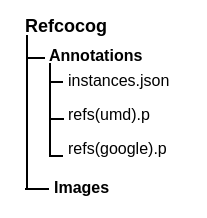

* refs(umd).p: is a pickle file containing the maping between the images and their referred captions and objects

* instances.json : contain general informations about the instances of the images and the sentences (for example it contains images general infos, taken date, file_name)

In [ ]:
# Load the data
umd_refs = np.load('/content/drive/MyDrive/visual-grounding/refcocog/annotations/refs(umd).p', allow_pickle=True)

In [ ]:
def zero_pad(x):
  width = 6
  padded_string = "%0*d" % (width, x)
  return padded_string

# getting all the sentences referiing an image:

def get_sents(x):
  sents = []
  for i in umd_refs:
    if i['image_id']==x:
      l = [ elt['sent'] for elt in i['sentences']]
      sents.extend(l)
  return sents

In [ ]:
d_train={}
d_test={}
d_val={}
IMAGE_DIR = "/content/drive/MyDrive/refcocog/images"
for e in umd_refs :
  if e['split'] == 'val' :
    d_val[osp.join(IMAGE_DIR,"COCO_train2014_000000"+zero_pad(e['image_id'])+".jpg")] = get_sents(e['image_id'])
  elif e['split'] == 'train' :
    d_train[osp.join(IMAGE_DIR,"COCO_train2014_000000"+zero_pad(e['image_id'])+".jpg")] = get_sents(e['image_id'])
  else :
    d_test[osp.join(IMAGE_DIR,"COCO_train2014_000000"+zero_pad(e['image_id'])+".jpg")] = get_sents(e['image_id'])

Here, we will perform data cleaning

In [ ]:
import re
import string

def text_cleaning (text):
  punctuation = ''.join([c for c in string.punctuation if c not in "','"])
  # Remove punctuation and convert to lowercase
  text = text.translate(str.maketrans('', '', punctuation)).lower()
  # Remove digits
  text = re.sub('\d', '', text)
  # Remove extra spaces
  text = re.sub('\s+', ' ', text).strip()
  return text

def data_cleaning (d) :
  d_cleaned = {}
  for image_path, descriptions in d.items():
    # Join all descriptions using a space character
    text = [text_cleaning(capt) for capt in descriptions]
    d_cleaned[image_path] = text
  return d_cleaned

d_val_clean=data_cleaning (d_val)
d_train_clean=data_cleaning (d_train)
d_test_clean=data_cleaning (d_test)

In [ ]:
l_descrip_train = []
l_img_train= []
for image_path, dec in d_train_clean.items():
  if os.path.isfile(image_path) :
    l_descrip_train.append(dec)
    l_img_train.append(image_path)

In [ ]:
l_descrip_val = []
l_img_val= []
for image_path, dec in d_val_clean.items():
  if os.path.isfile(image_path) :
    l_descrip_val.append(dec)
    l_img_val.append(image_path)

In [ ]:
l_descrip_test = []
l_img_test= []
for image_path, dec in d_test_clean.items():
  if os.path.isfile(image_path) :
    l_descrip_test.append(dec)
    l_img_test.append(image_path)

In [ ]:
captions = []
images = []
def method_1(l_desc,l_img) :
  i=0
  for elt in l_desc :
    for e in elt :
      captions.append(e)
      images.append(l_img[i])
    i+=1
  return captions, images

In [ ]:
captions_test, images_test = method_1(l_descrip_test,l_img_test)
captions_train, images_train = method_1(l_descrip_train,l_img_train)
captions_val, images_val = method_1(l_descrip_val,l_img_val)

In [ ]:
class image_title_dataset(Dataset):
  def __init__(self, list_image_path,list_txt):
    self.image_path = list_image_path
    self.title  = clip.tokenize(list_txt) #you can tokenize everything at once in here(slow at the beginning), or tokenize it in the training loop.

  def __len__(self):
    return len(self.title)

  def __getitem__(self, idx):
    image = preprocess(Image.open(self.image_path[idx])) # Image from PIL module
    title = self.title[idx]
    return image,title

In [ ]:
dataset = image_title_dataset(images_val,captions_val)
train_dataloader = DataLoader(dataset,batch_size = 32) #Define your own dataloader

In [ ]:
def convert_models_to_fp32(model):
    for p in model.parameters():
        p.data = p.data.float()
        p.grad.data = p.grad.data.float()

In [ ]:
if device == "cpu":
  model.float()
else :
  clip.model.convert_weights(model)


Wandb (Weights & Biases) is a tool and platform that provides experiment tracking, visualization, and collaboration for machine learning and deep learning projects.

We are utilizing Wandb for experiment tracking and visualization.
With Wandb, we can easily log important parameters, metrics, and hyperparameters, visualize training progress and evaluation results, and share our findings.

In [ ]:
import wandb

# Define the sweep configuration
sweep_config = {
    "name": "My Sweep",
    "method": "random",
    "metric":
        {
            "name": "train_loss",
            "goal": "minimize"
        },
    "parameters":
        {
            "optimizer": {'values' : ["adam", "rmsprop", "sgd"]},

            "learning_rate":{'max': 0.01, 'min': 0.00001},
            "beta1":{'min': 0.8, 'max': 0.9,"distribution": "uniform"},
            "beta2":{'min': 0.95, 'max': 0.99,"distribution": "uniform"},
            "eps":{'min': 1e-7, 'max': 1e-5,"distribution": "uniform"},
             "epochs": {'values': [10, 20, 30]},

             "loss_function": {'values' : ["cross_entropy", "mse", "kl_divergence"]}

}
}

In [ ]:
import wandb
# Initialize W&B
wandb.init(project="my-clip-project", name="clip-training")

# Initialize W&B Sweep
sweep_id = wandb.sweep(sweep_config, project="my-clip-project")

# Log some hyperparameters
#config = wandb.config
#config.learning_rate = 5e-5
#config.batch_size = 32
#config.beta1 = 0.9
#config.beta2 = 0.98
#config.eps = 1e-6
#config.weight_decay = 0.2

Finetune the clip model

In [ ]:
def train_with_config():
  # Initialize W&B
  wandb.init(project="my-clip-project", name="clip-training", config=wandb.config)

  # Log some hyperparameters
  config = wandb.config
  config.beta1 = 0.9
  config.beta2 = 0.98
  config.eps = 1e-6

  EPOCH = wandb.config.epoch

  metrics = {'train_loss': [], 'val_loss': []}
  for epoch in range(EPOCH):

    train_losses = []
    model.train()  # set the model to training mode

    if wandb.config.loss_function == "cross_entropy":
      loss_img = nn.CrossEntropyLoss()
      loss_txt = nn.CrossEntropyLoss()
    elif wandb.config.loss_function == "mse":
      loss_img = nn.MSELoss()
      loss_txt = nn.MSELoss()
    elif wandb.config.loss_function == "kl_divergence":
      loss_img = nn.KLDivLoss()
      loss_txt = nn.KLDivLoss()

    if wandb.config.optimizer == "adam":
      optimizer = optim.Adam(model.parameters(), lr=wandb.config.learning_rate, betas=(wandb.config.beta1, wandb.config.beta2), eps=wandb.config.eps, weight_decay=wandb.config.weight_decay)
    elif wandb.config.optimizer == "rmsprop":
      optimizer = optim.RMSprop(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)
    elif wandb.config.optimizer == "sgd":
      optimizer = optim.SGD(model.parameters(), lr=wandb.config.learning_rate, weight_decay=wandb.config.weight_decay)


    for batch in train_dataloader :
      optimizer.zero_grad()

      images,texts = batch

      images= images.to(device)
      texts = texts.to(device)

      logits_per_image, logits_per_text = model(images, texts)

      ground_truth = torch.arange(len(images),dtype=torch.long,device=device)

      total_loss = (loss_img(logits_per_image,ground_truth) + loss_txt(logits_per_text,ground_truth))/2
      total_loss.backward()

      if device == "cpu":
        optimizer.step()
      else :
        convert_models_to_fp32(model)
        optimizer.step()
        clip.model.convert_weights(model)

      train_losses.append(total_loss.item())
    train_loss = sum(train_losses) / len(train_losses)

    # Log metrics with W&B
    wandb.log({"epoch": epoch + 1, "train_loss": train_loss})

    # Print progress
    print(f'Epoch {epoch + 1}/{EPOCH}, Train Loss: {train_loss:.4f}')

In [ ]:
# Run the sweep
wandb.agent(sweep_id, function=train_with_config)

# Evaluating Fine-Tuned CLIP Model Performance for Text-Image Similarity

In this code snippet, we will evaluate the performance of a fine-tuned CLIP model in augmenting similarities between similar text and image pairs. We aim to measure how well the model can encode and compare the textual and visual features of the pairs.

The similarity scores are accumulated, and the cumulative sum is calculated for both models. Finally, a plot of the cumulative similarity scores is generated to visualize and compare the performance of the two models.

In [ ]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device, jit=False)

finetuned_clip_model, preprocess = clip.load("RN50", device=device, jit=False)
finetuned_clip_model.load_state_dict(torch.load("/content/drive/MyDrive/model_2.pt", map_location=device)['model_state_dict'])

<All keys matched successfully>

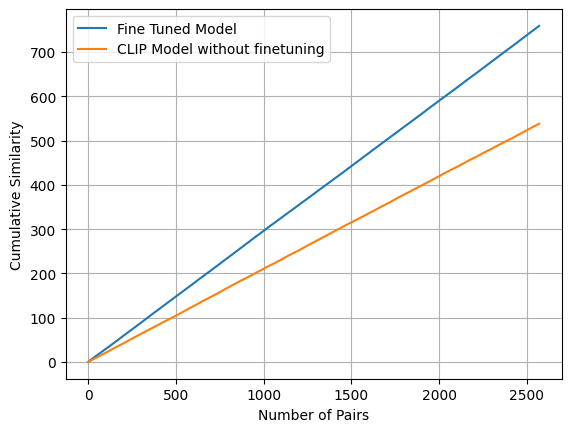

In [ ]:
import csv
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

# Set the device to GPU if available, otherwise CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

finetuned_clip_model.to(device)
clip_model.to(device)

# Encode images and texts and calculate cosine similarity
similarity_model1 = []
similarity_model2 = []

validation_data = pd.read_csv('/content/drive/MyDrive/visual-grounding/validation_dataset.csv')


image_path = validation_data['file_name'].to_list()
text = validation_data['sentences'].to_list()

for i in range(len(text)):
    # Check if the image path exists
    if os.path.exists(image_path[i]):
        # Encode the image and text
        with torch.no_grad():
            image = preprocess(Image.open(image_path[i])).unsqueeze(0).to(device)
            image_embedding1 = finetuned_clip_model.encode_image(image)
            image_embedding2 = clip_model.encode_image(image)

            text_1 = clip.tokenize(text[i]).to(device)
            text_embedding1 = finetuned_clip_model.encode_text(text_1)
            text_embedding2 = clip_model.encode_text(text_1)

        # Calculate the cosine similarity
        similarity_model1.append(torch.nn.functional.cosine_similarity(image_embedding1, text_embedding1).item())
        similarity_model2.append(torch.nn.functional.cosine_similarity(image_embedding2, text_embedding2).item())
    else:
        print("Image path does not exist:", image_path[i])

# Calculate the cumulative sum
cumulative_similarity_model1 = np.cumsum(similarity_model1)
cumulative_similarity_model2 = np.cumsum(similarity_model2)

# Plot the cumulative similarity
plt.plot(cumulative_similarity_model1, label='Fine Tuned Model')
plt.plot(cumulative_similarity_model2, label='CLIP Model without finetuning')
plt.xlabel('Number of Pairs')
plt.ylabel('Cumulative Similarity')
plt.legend()
plt.grid(True)
plt.show()

# Visual Grounding

# Dataset and DataLoader

## Data processing

The dataset consists of images along with their corresponding ground truth bounding boxes.

We have generated a CSV files that contain mainly the sentences and their ground truth bounding boxes and the information about all the bounding boxes that were generated by a YOLO-NAS, which is trained on the coco dataset, for a giving image. These bounding boxes serves as region proposals from which the referred bbox will be chosen later.


In [ ]:
# Modify the path: Because we used the VM so the path started by: /home/disi
def modify_path (ch):
  pos_1 = ch.find(".")
  pos_2 = ch.find("_",15)
  ch = ch[0:pos_2]+ch[pos_1:]
  ch = "/content/drive/MyDrive/visual-grounding/refcocog/images/"+ch
  return ch

In [ ]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/clip_dataset.csv")
data['file_name'] = data['file_name'].apply(modify_path)

In [ ]:
import os
data['Path_Exists'] = data['file_name'].apply(lambda x: os.path.exists(x))
data = data[data['Path_Exists']]

In [ ]:
# Remove the 'Path_Exists' column
data = data.drop('Path_Exists', axis=1)

In [ ]:
# Split the data into separate DataFrames based on the 'Subset' column
train_data = data[data['split'] == 'train']
test_data = data[data['split'] == 'test']
valid_data = data[data['split'] == 'val']

In [ ]:
import ast

# Apply ast.literal_eval() to the data_column
train_data['sentences'] = train_data['sentences'].apply(ast.literal_eval)
test_data['sentences'] = test_data['sentences'].apply(ast.literal_eval)
valid_data['sentences'] = valid_data['sentences'].apply(ast.literal_eval)

Considering the constraint of max length of 77 in the clip text encoder, We have decided to use only one sentence for each object.

Here we chose only one sentence describing an object represented by a bounding box

* We tried to use Pegasus to summary the sentences, but we have noticed that the divergence of the sense of the description to a more general one, so we decided not to continue with and we chose only the first sentence.

In [ ]:
# Update the data_column to keep only the first element in each row
train_data['sentences'] = train_data['sentences'].apply(lambda x: x[0]['sent'])
test_data['sentences'] = test_data['sentences'].apply(lambda x: x[0]['sent'])
valid_data['sentences'] = valid_data['sentences'].apply(lambda x: x[0]['sent'])

In [ ]:
# Only the senteces, file_name, category_id and ground truth bbox will be kept
train_data = train_data[["sentences","file_name","category_id_x","bbox"]]
test_data = test_data[["sentences","file_name","category_id_x","bbox"]]
valid_data = valid_data[["sentences","file_name","category_id_x","bbox"]]

In [ ]:
!pip install ultralytics
!pip install super_gradients

In [ ]:
import super_gradients
from PIL import Image
import torch
from torchvision import transforms

In [ ]:
# Load yolo NAS model
yolo_nas = super_gradients.training.models.get("yolo_nas_l", pretrained_weights="coco").cuda()

In [ ]:
def param_yolo_nas(im_path) :
  with torch.no_grad():
    predictions = yolo_nas.predict(im_path, conf=0.3)
    prediction_objects = list(predictions._images_prediction_lst)[0]
    bboxes = prediction_objects.prediction.bboxes_xyxy
    int_labels = prediction_objects.prediction.labels.astype(int)
    conf = prediction_objects.prediction.confidence
  l=[]
  for i in range(len(int_labels)) :
    d={}
    d['class_id'] = int_labels[i]
    d['score'] = conf[i]
    d['bbox'] = list(bboxes[i])
    l.append(d)
  return l

Considering the constraint of handling a large dataset, you have made a practical decision to work with a subset of the data (20,000)

In [ ]:
import random

# Set the seed for reproducibility (optional)
random.seed(42)

# Randomly select 20,000 rows from the original dataset
sample_train_data = train_data.sample(n=20000)

In [ ]:
sample_train_data['yolo_result'] = sample_train_data['file_name'].apply(lambda x: param_yolo_nas(x))

In [ ]:
len(sample_train_data)

In [ ]:
# Save the DataFrame as a CSV file
sample_train_data.to_csv('/content/drive/MyDrive/visual-grounding/train_dataset.csv', index=False)

___________________________

## Custom Dataset class and dataloader

we load the processed data that we saved

In [ ]:
# Loading data
data_train = pd.read_csv('/content/drive/MyDrive/visual-grounding/train_dataset.csv')
data_val = pd.read_csv('/content/drive/MyDrive/visual-grounding/validation_dataset.csv')
#data_test = pd.read_csv('/content/drive/MyDrive/visual-grounding/test_dataset.csv')

In [ ]:
import ast

# Convert columns in data_val from string representation to a list

data_val["yolo_result"] = data_val["yolo_result"].apply(ast.literal_eval)
data_val["bbox"] = data_val["bbox"].apply(ast.literal_eval)

data_train["yolo_result"] = data_train["yolo_result"].apply(ast.literal_eval)
data_train["bbox"] = data_train["bbox"].apply(ast.literal_eval)

#data_test["yolo_result"] = data_test["yolo_result"].apply(ast.literal_eval)
#data_test["bbox"] = data_test["bbox"].apply(ast.literal_eval)

In [ ]:
# Select rows from data where the length of the image have more than 8 yolo predictions

df_exp_train = data_train[data_train["yolo_result"].apply(lambda x: len(x)) > 8]
df_exp_val = data_val[data_val["yolo_result"].apply(lambda x: len(x)) > 8]
df_exp_test = data_val[data_val["yolo_result"].apply(lambda x: len(x)) > 1]

In [ ]:
df_exp_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7949 entries, 1 to 19997
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   sentences      7949 non-null   object
 1   file_name      7949 non-null   object
 2   category_id_x  7949 non-null   int64 
 3   bbox           7949 non-null   object
 4   yolo_result    7949 non-null   object
dtypes: int64(1), object(4)
memory usage: 372.6+ KB



We have developed a custom class called **Refcocog** to handle specific dataset splits (train, val, or test) for the task of visual grounding.

The primary purpose of this code is to simplify the loading and processing of data for the visual grounding task. It ensures that the required information is extracted, transformed, and prepared for training or evaluation.


During training (when self.is_training=True), the code operates on each item of the data using the getitem method.
It performs the following steps: loading the image, applying transformations, and retrieving the associated sentences. Additionally, it handles region proposals generated by the YOLO algorithm in earlier steps. It filters and combines valid bounding boxes, resizing them to a fixed size. The code also calculates the Intersection over Union (IoU) between the region proposals and the ground truth bounding box. If the IoU is greater than or equal to 0.5, it determines the best matching proposal and assigns it as the ground truth for training. Bounding boxes with an IoU less than 0.5 are assigned the "ignore index," indicating that they should be disregarded during training.

In summary, the code provides us with an image, its corresponding description, a specified number of proposals (num_rpns_per_image), and the index of the ground truth among these proposals.

In [ ]:
import numpy as np

def calculate_iou(boxes_a, boxes_b):
    # Calculate the Intersection over Union (IoU) between boxes_a and boxes_b

    # Compute the coordinates of the intersection area
    left_top = np.maximum(boxes_a[:, np.newaxis, :2], boxes_b[:, :2])
    right_bottom = np.minimum(boxes_a[:, np.newaxis, 2:], boxes_b[:, 2:])

    # Calculate the width and height of the intersection area
    intersection = np.clip(right_bottom - left_top, 0, None)

    # Calculate the area of the intersection
    area_intersection = np.prod(intersection, axis=2)

    # Calculate the area of each box
    area_a = np.prod(boxes_a[:, 2:] - boxes_a[:, :2], axis=1)
    area_b = np.prod(boxes_b[:, 2:] - boxes_b[:, :2], axis=1)

    # Calculate the area of the union
    area_union = area_a[:, np.newaxis] + area_b - area_intersection

    # Calculate the IoU for each pair of boxes
    iou = area_intersection / np.clip(area_union, 1e-7, None)

    return iou



---


first of all we create the function that we will use to calculate the iou between proposals and the gt

In [ ]:
# Dataset class
import ast
import pandas as pd

class Refcocog(data.Dataset):
  def __init__(self, split, image_dir, transform=None):
    # Get the data from the csv
    #df = pd.read_csv(dataset_path, encoding='latin-1')
    self.split = split
    self.image_dir = image_dir
    self.transform = transform

    # The data
    if self.split=='train':
      self.data = df_exp_train
    elif self.split=='val':
      self.data = df_exp_val
    elif self.split=='test':
      self.data =df_exp_test
    else:
      self.data = None

    # Add extra info( ground truth bboxes) when reading out items for training
    if self.split in ['val','train']:
      self.is_training = True
    else:
      self.is_training = False

    # From code
    self.ignore_index = 255
    self.num_rpns_per_image = 8 #the number of proposals by image



  def __len__(self):
    return len(self.data)


  def __getitem__(self, idx):
    output = {'index': torch.LongTensor([idx])}
    sample = self.data.iloc[idx]

    # Load and transform the image
    output['image_link']= sample.file_name
    image = Image.open(sample.file_name).convert('RGB')  # Load the image
    image = self.transform(image)  # Apply transformations
    output['image'] = image

    # Load sentences
    output['sentence'] = sample.sentences

    # Load region proposals obtained with yolo (bounding boxes as x1y1x2y2)
    if len(sample.yolo_result) > 0:
        #bboxes = [torch.LongTensor(bbox['bbox']) for bbox in sample.yolo_result[:self.num_rpns_per_image]]

        bboxes = torch.stack([torch.LongTensor(sample['yolo_result'][i]["bbox"]) for i in range(self.num_rpns_per_image)])

        # Filter valid bounding boxes based on size and stack them into a tensor (Remove boxes that are to small)
        #bbox_xyxy = torch.stack([bbox for bbox in bboxes if bbox[3] - bbox[1] > 5 and bbox[2] - bbox[0] > 5], 0)
        bbox_xyxy = torch.stack([bboxes[:,0], bboxes[:,1], bboxes[:,2], bboxes[:,3]], 1)
        bbox_xyxy[:, 0].clamp_(0, 1600)  # Clamp x1
        bbox_xyxy[:, 1].clamp_(0, 900)  # Clamp y1
        bbox_xyxy[:, 2].clamp_(0, 1600)  # Clamp x2
        bbox_xyxy[:, 3].clamp_(0, 900)  # Clamp y2
        output['rpn_bbox_xyxy'] = bbox_xyxy

        rpn_image = torch.zeros(self.num_rpns_per_image, 3, 224, 224)
        for i, bbox in enumerate(bbox_xyxy):
            # Extract region of interest from the image and resize to fixed size
            rpn_image[i] = torch.nn.functional.interpolate(
                image[:, bbox[1]:bbox[3], bbox[0]:bbox[2]].unsqueeze(0),
                size=(224, 224)).squeeze()
        output['rpn_image'] = rpn_image

    output['image'] = torch.nn.functional.interpolate(image.unsqueeze(0), size=(224, 224)).squeeze()

    if self.is_training:
        gt = sample.bbox
        #transform box coordinate from xyxy to xywh
        x1, y1, x2, y2 = gt[0], gt[1], gt[0] + gt[2], gt[1] + gt[3]
        output['gt_bbox_xyxy'] = torch.LongTensor([x1, y1, x2, y2])

        # Calculate IoU between region proposals and ground truth bbox
        iou_array = calculate_iou(output['rpn_bbox_xyxy'].numpy(), output['gt_bbox_xyxy'].numpy().reshape(1, -1))
        output['rpn_iou'] = torch.from_numpy(iou_array)
        # gT is the proposal with best overlap.
        # If the IoU<0.5 for the best box, then the "ignore index" is assigned to indicate that the bounding box should be ignored during training.
        if np.any(iou_array >= 0.5):
            gt = torch.LongTensor([np.argmax(iou_array)])  # Best matching is gt for training
            output['rpn_gt'] = gt
        else:
            output['rpn_gt'] = torch.LongTensor([self.ignore_index])  # ignore non good bboxes

    return output

=> Load a sample

---------- Caption ------------

a man with glasses in a white shirt and black pants sitting on a wooden bench reading some papers

 ------------------------------ 

=> Plot image with bounding box around referred object


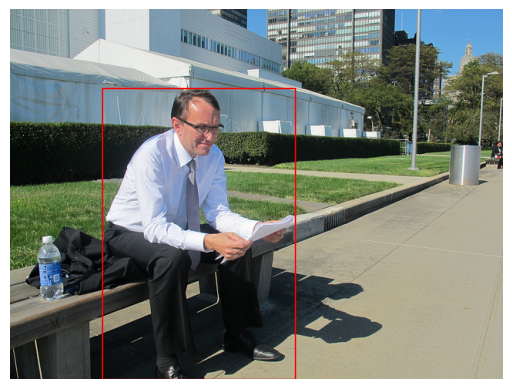

=> Plot image with region proposals (red), gt bbox (blue)


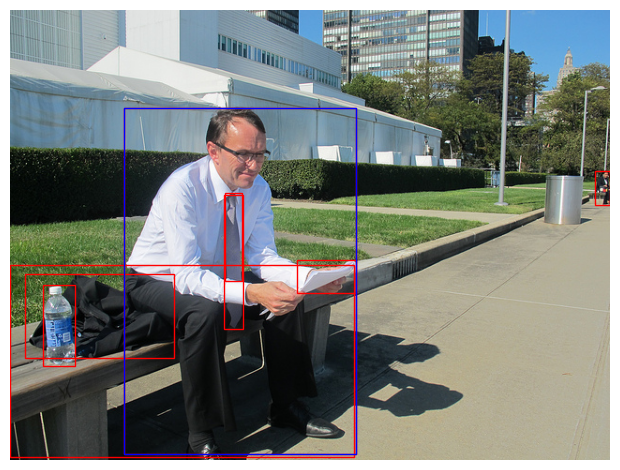

In [ ]:
""" A simple example """
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches

dataset = Refcocog(split='val', image_dir='/content/drive/MyDrive/visual-grounding/refcocog/images', transform=transforms.ToTensor())

print('=> Load a sample')
sample = dataset.__getitem__(10)
img = np.transpose(sample['image'].numpy(), (1,2,0))
img_org=Image.open(sample['image_link']).convert('RGB')

print('\n---------- Caption ------------\n')
print(sample['sentence'])
print('\n ------------------------------ \n')

print('=> Plot image with bounding box around referred object')
fig, ax = plt.subplots(1)
ax.imshow(img_org)
xl, yb, xr, yt = sample['gt_bbox_xyxy'].tolist()
w, h = xr - xl, yt - yb
rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'r')
ax.add_patch(rect)
plt.axis('off')
plt.show()

print('=> Plot image with region proposals (red), gt bbox (blue)')
fig, ax = plt.subplots(1)
ax.imshow(img_org)
for i in range(sample['rpn_bbox_xyxy'].size(0)):
    bbox = sample['rpn_bbox_xyxy'][i].tolist()
    xl, yb, xr, yt = bbox
    w, h = xr - xl, yt - yb
    rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'r')
    ax.add_patch(rect)

gt_box = (sample['rpn_bbox_xyxy'][sample['rpn_gt'].item()]).tolist()
xl, yb, xr, yt = gt_box
w, h = xr - xl, yt - yb

rect = patches.Rectangle((xl, yb), w, h, fill = False, edgecolor = 'b')
ax.add_patch(rect)
plt.axis('off')
plt.tight_layout()
plt.show()

# Training and evaluation

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-x5x4keq4
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-x5x4keq4
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done


## Defining metrics class

In [ ]:
import torch
import shutil


def save_checkpoint(state, new_best):
    torch.save(state, '/content/drive/MyDrive/visual-grounding/checkpoint.pth.tar')
    if new_best:
        shutil.copy('/content/drive/MyDrive/visual-grounding/checkpoint.pth.tar', '/content/drive/MyDrive/visual-grounding/best_model.pth.tar')

class AverageMetric(object):
    """Computes and stores the average and current value of a metric"""
    def __init__(self, metric_name, fmt=':f'):
        self.metric_name = metric_name
        self.fmt = fmt
        self.reset()

    def reset(self):
        self.value = 0
        self.average = 0
        self.summation = 0
        self.count = 0

    def update(self, value, n=1):
        self.value = value
        self.summation += value
        self.count += n
        if self.count > 0:
            self.average = self.summation / self.count

    def __str__(self):
        fmtstr = '{name} {avg' + self.fmt + '}'
        return fmtstr.format(name=self.metric_name, avg=self.average)


class ProgressMetric(object):
    def __init__(self, num_batches, metrics, prefix=""):
        self.batch_format_str = self._get_batch_format_str(num_batches)
        self.metrics = metrics
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_format_str.format(batch)]
        entries += [str(metric) for metric in self.metrics]
        print('\t'.join(entries))

    def _get_batch_format_str(self, num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

## The proposed solution and defining training and evaluation step functions

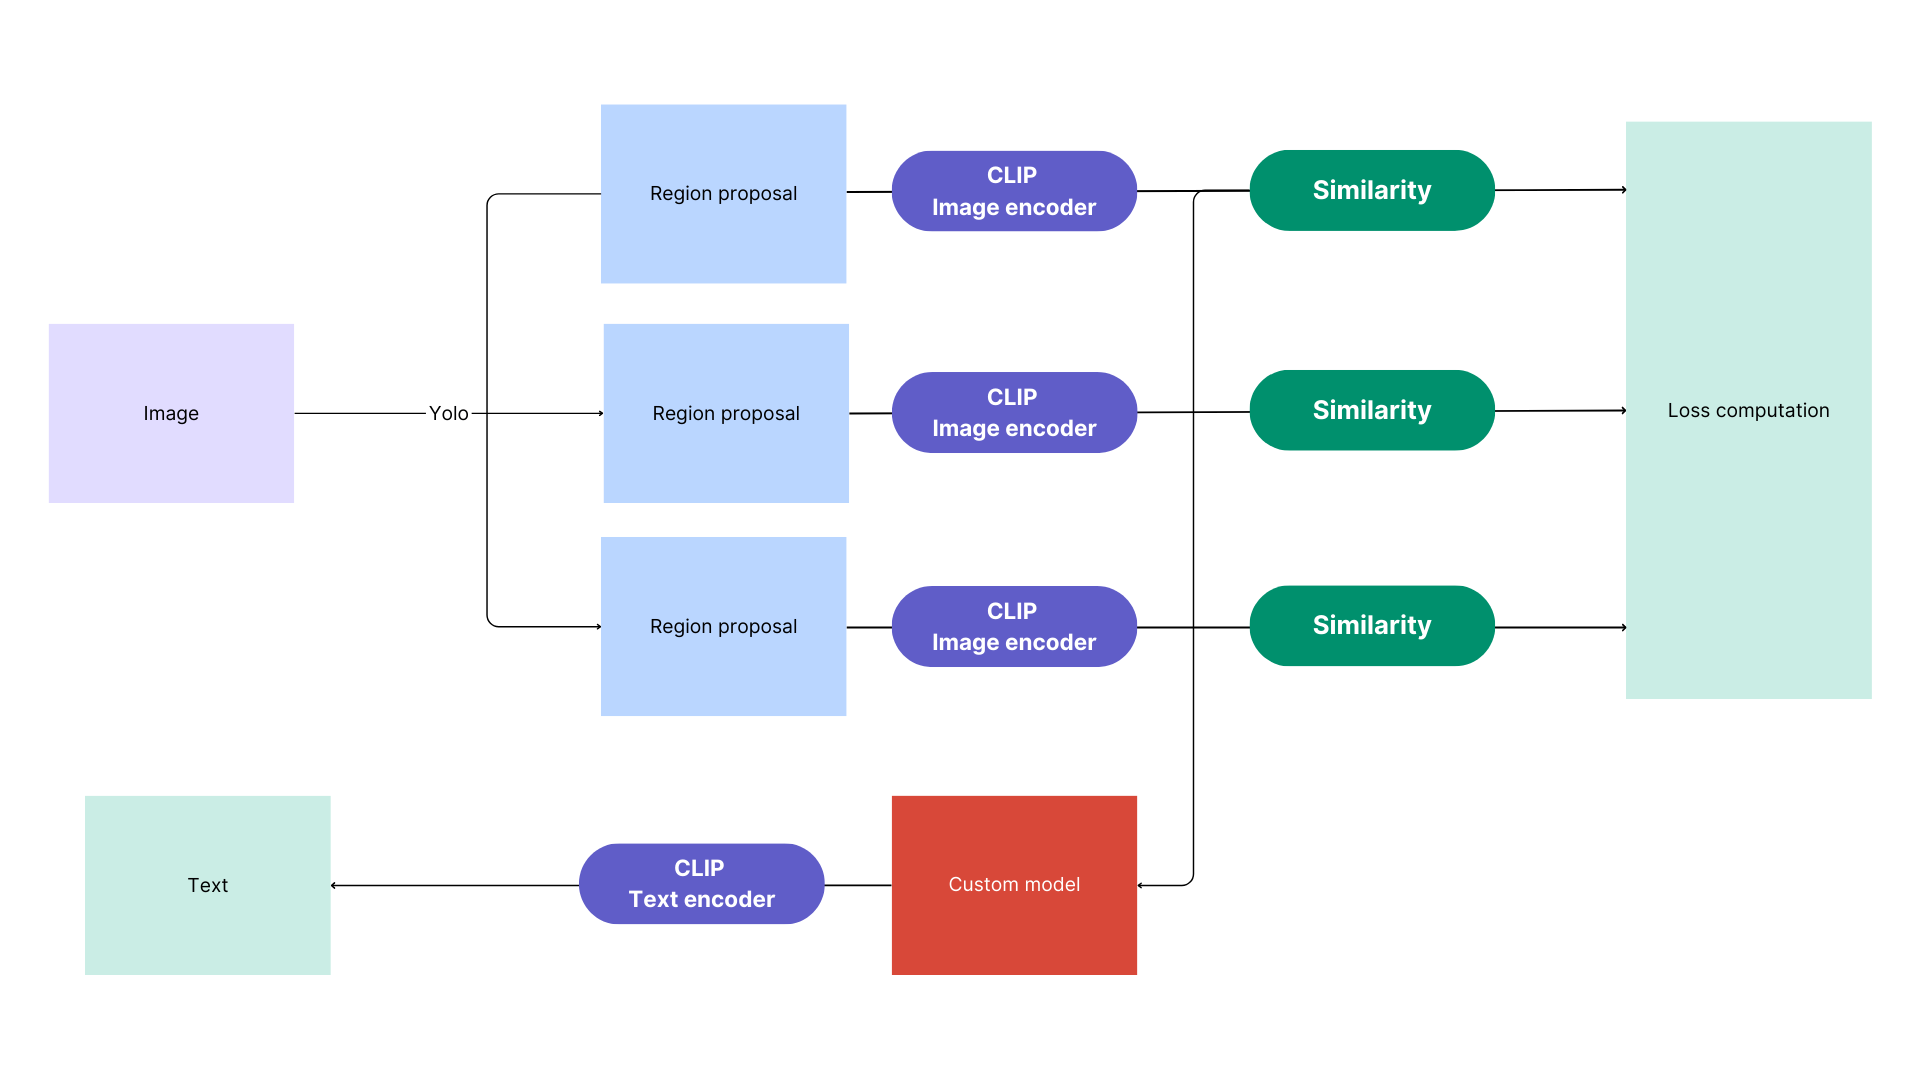
The main concept behind this approach is to evaluate how well a bounding box aligns with a given sentence. To achieve this, we calculate dot product![Image.png]() similarity scores between the Clip encodings of the region proposals (bounding boxes) and the text. It is important to note that the text itself is encoded using Clip and also passed through a custom model.
These scores provide a quantitative measure of the alignment between the bounding box and the sentence.

To improve the model's performance, we compute a training loss based on these similarity scores and the ground truth labels. This loss is then used in the optimization process through backpropagation, which updates the model's parameters iteratively. The goal is to minimize the loss and enhance the model's ability to generate accurate predictions.

By incorporating the CLIP model for various tasks such as visual and textual feature extraction the code streamlines the training procedure for a customized model.



---


Using that as a foundation, we can establish the remaining elements of the training process, including the functions for training and evaluation steps.


In this study, the selected evaluation metrics were as follows: :


1.   AP50: Measures the precision of object localization with an IoU threshold of 0.50.
2.   Top-1 Accuracy: Represents the percentage of correct predictions for the most confident label.
3. IoU (Intersection over Union): Quantifies the overlap between predicted and ground truth bounding boxes.






In [ ]:
def train(train_dataloader, clip_model, custom_model, optimizer, cost_function,epoch):
    m_losses =AverageMetric('Loss', ':.4e')
    m_top1 = AverageMetric('Acc@1', ':6.2f')
    m_iou = AverageMetric('IoU', ':6.2f')
    m_ap50 = AverageMetric('AP50', ':6.2f')
    progress = ProgressMetric(
                len(train_dataloader),
                [m_losses, m_top1, m_iou, m_ap50], prefix="Epoch: [{}]".format(epoch))


    custom_model.train()
    clip_model.train()

    ignore_index = train_dataloader.dataset.ignore_index


    for i, batch in enumerate(train_dataloader):


        # Data
        region_proposals = batch['rpn_image'].cuda(non_blocking=True)
        sentence = batch['sentence']
        gt = batch['rpn_gt'].cuda(non_blocking=True)
        iou = batch['rpn_iou'].squeeze().cuda(non_blocking=True).squeeze()
        batch_size, r, c, h, w = region_proposals.size() # r: Number of region proposals in each sample
                                                         # c: Number of channels in the region proposals
                                                         # h: Height of each region proposal
                                                         # w: Width of each region proposal


        # Image features
        img_features = clip_model.encode_image(region_proposals.view(batch_size * r, c, h, w))  # Encode region_proposals using clip_model
        norm = img_features.norm(p=2, dim=1, keepdim=True)  # Compute L2 norm of img_features
        img_features = img_features.div(norm).view(batch_size, r, -1)  # Normalize and reshape img_features

        # Preprocess the sentence
        input_text = clip.tokenize(sentence).to(device)

        # Encode the sentence features using the CLIP model
        with torch.no_grad():
            sentence_features = clip_model.encode_text(input_text)


        # Pass the sentence features through the custom model
        sentence_features = custom_model(sentence_features)
        sentence_features = sentence_features.unsqueeze(2)  # Add an extra dimension to sentence_features


        img_features = img_features.to(device, dtype=torch.float32)
        sentence_features = sentence_features.to(device, dtype=torch.float32)

        # Compute similarity scores using batch matrix multiplication between image and sentence features
        scores = torch.bmm(img_features, sentence_features).squeeze()
        gt = gt.squeeze()

        # Loss
        total_loss = cost_function(scores, gt) #compute loss


        # Update

        total_loss.backward()
        optimizer.step()
        optimizer.zero_grad()


        # Summary
        pred = torch.argmax(scores, 1)  # Get the index of the maximum score for each sample
        pred_bin = F.one_hot(pred, r).bool()  # Convert the predicted indices to one-hot representation
        valid = (gt != ignore_index)  # Create a mask to filter out samples where gt is equal to the ignore index
        num_valid = torch.sum(valid).float().item()  # Count the number of valid samples
        m_top1.update(torch.sum(pred[valid] == gt[valid]).float().item(), num_valid)  # Update top-1 accuracy metric by counting the number of correct predictions among valid samples
        m_iou.update(torch.masked_select(iou, pred_bin).sum().float().item(), batch_size)  # Update IoU metric by summing the IoU values for predicted regions that match ground truth regions, divided by batch size
        m_ap50.update((torch.masked_select(iou, pred_bin) > 0.5).sum().float().item(), batch_size)  # Update AP50 metric by counting the number of predicted regions with IoU greater than 0.5, divided by batch size
        m_losses.update(total_loss.item())  # Update the loss metric with the current total loss value

        if i % print_freq==0:
            progress.display(i)

    return m_ap50.average ,m_losses.average

In [ ]:
@torch.no_grad()
def evaluate_model(val_dataloader, clip_model,custom_model,cost_function):
    m_losses = AverageMetric('Loss', ':.4e')
    m_top1 = AverageMetric('Acc@1', ':6.2f')
    m_iou = AverageMetric('IoU', ':6.2f')
    m_ap50 = AverageMetric('AP50', ':6.2f')
    progress = ProgressMetric(
                len(val_dataloader),
                [m_top1, m_iou, m_ap50],
                prefix='Test: ')

    custom_model.eval()
    clip_model.eval()

    ignore_index = val_dataloader.dataset.ignore_index

    for i, batch in enumerate(val_dataloader):

        # Data
        region_proposals = batch['rpn_image'].cuda(non_blocking=True)
        sentence = batch['sentence']
        gt = batch['rpn_gt'].cuda(non_blocking=True)

        iou = batch['rpn_iou'].cuda(non_blocking=True).squeeze()
        batch_size, r, c, h, w = region_proposals.size()

        # Image features
        img_features = clip_model.encode_image(region_proposals.view(batch_size*r, c, h, w))
        norm = img_features.norm(p=2, dim=1, keepdim=True)
        img_features = img_features.div(norm).view(batch_size, r, -1)

        # Preprocess the sentence
        input_text = clip.tokenize(sentence).cuda()

        # Encode the sentence features using the CLIP model

        sentence_features = clip_model.encode_text(input_text)

        # Convert the sentence_features tensor to torch.float32
        sentence_features = sentence_features.to(torch.float32)

        # Pass the sentence features through the custom model
        sentence_features = custom_model(sentence_features)

        sentence_features = sentence_features.unsqueeze(2)

        img_features = img_features.to(device, dtype=torch.float32) #.float()
        sentence_features = sentence_features.to(device, dtype=torch.float32) #.float()

        # Product in latent space
        scores = torch.bmm(img_features, sentence_features).squeeze()
        gt = gt.squeeze()
        total_loss = cost_function(scores, gt)
        # Summary
        pred = torch.argmax(scores, 1)
        pred_bin = F.one_hot(pred, r).bool()
        valid = (gt!=ignore_index)
        num_valid = torch.sum(valid).float().item()
        m_top1.update(torch.sum(pred[valid]==gt[valid]).float().item(), num_valid)
        m_iou.update(torch.masked_select(iou, pred_bin).sum().float().item(), batch_size)
        m_ap50.update((torch.masked_select(iou, pred_bin) > 0.5).sum().float().item(), batch_size)
        m_losses.update(total_loss.item())

        if i % print_freq==0:
            progress.display(i)

    return m_ap50.average ,m_losses.average

we define training parameters

In [ ]:
root = '/content/drive/MyDrive/visual-grounding/refcocog/images'
workers = 0
epochs = 60
start_epoch = 0
batch_size = 16
lr = 0.0001
milestones = [4, 8]
momentum = 0.9
nesterov = True
weight_decay = 1e-4
print_freq = 10


In this work, we used a simple custom model comprising three layers: a linear layer with 1024 input units and 1000 output units, followed by a ReLU activation function, and another linear layer with 1000 input units and 1024 output units.

For the cost function, we select the cross-entropy loss. The "ignore_index" parameter is set based on the "train_dataset" object, and the reduction method is chosen to calculate the mean of the loss values.

The optimizer is defined as an instance of the SGD (Stochastic Gradient Descent) algorithm.

Lastly, a learning rate scheduler is established using the optim.lr_scheduler.MultiStepLR class. It adjusts the learning rate of the optimizer based on predefined milestones and a decay factor (gamma).

---


We now integrate all the components within the main function and execute them subsequently.

## main loop

we import the fine tuned clip model

In [ ]:
import clip
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("RN50", device=device, jit=False)
model.load_state_dict(torch.load("/content/drive/MyDrive/model_2.pt", map_location=device)['model_state_dict'])

100%|███████████████████████████████████████| 244M/244M [00:04<00:00, 53.1MiB/s]


<All keys matched successfully>

In [ ]:
from torch.utils.tensorboard import SummaryWriter

# tensorboard logging utilities
def log_values(writer, step, loss, accuracy, prefix):
  writer.add_scalar(f"{prefix}/loss", loss, step)
  writer.add_scalar(f"{prefix}/accuracy", accuracy, step)


def main(clip_model):
    """
    Main function for training and evaluating a custom model.

    Args:
        clip_model (torch.nn.Module): The CLIP model used as a feature extractor.
    """
    # create a logger for the experiment
    writer = SummaryWriter(log_dir="/content/drive/MyDrive/visual-grounding/runs")

    print("=> creating dataset")

    # Set the device to use CUDA if available
    device = torch.device('cuda')

    # Define the normalization parameters for the dataset
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Create training and validation datasets
    train_dataset = Refcocog(split='train', image_dir='/content/drive/MyDrive/visual-grounding/refcocog/images',
                            transform=transforms.Compose([transforms.ToTensor(), normalize]))
    val_dataset = Refcocog(split='val', image_dir='/content/drive/MyDrive/visual-grounding/refcocog/images',
                          transform=transforms.Compose([transforms.ToTensor(), normalize]))

    # Create data loaders for training and validation
    train_dataloader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                       num_workers=workers, pin_memory=True, drop_last=True)
    val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                     num_workers=workers, pin_memory=True, drop_last=False)

    print("=> creating model")

    # Convert the clip_model to the float data type
    clip_model = clip_model.float()

    # Create the custom model architecture with two linear layers and ReLU activation
    custom_model = nn.Sequential(nn.Linear(1024, 1000), nn.ReLU(), nn.Linear(1000, 1024))

    # Move the custom model and clip model to the specified device
    custom_model.to(device)
    clip_model.to(device)

    # Define the cost function for training as the cross-entropy loss
    cost_function = nn.CrossEntropyLoss(ignore_index=train_dataset.ignore_index, reduction='mean')

    # Move the cost function to the specified device
    cost_function.to(device)

    # Enable cudnn benchmark for improved performance
    cudnn.benchmark = True

    print("=> creating optimizer and scheduler")

    # Create the optimizer and scheduler for training
    params = list(clip_model.parameters()) + list(custom_model.parameters())
    optimizer = optim.SGD(params, lr=lr, momentum=momentum,
                          weight_decay=weight_decay, nesterov=nesterov)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    # Define the path to the checkpoint file
    checkpoint = '/content/drive/MyDrive/visual-grounding/checkpoint.pth.tar'

    if os.path.exists(checkpoint):
        # If a checkpoint file exists, load it and restore the models, optimizer, scheduler, epoch, and best AP50 score
        print("=> resume from checkpoint at %s" % (checkpoint))
        checkpoint = torch.load(checkpoint, map_location='cpu')
        clip_model.load_state_dict(checkpoint['clip_model'])
        custom_model.load_state_dict(checkpoint['fc_model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        scheduler.load_state_dict(checkpoint['scheduler'])
        start_epoch = checkpoint['epoch']
        best_ap50 = checkpoint['best_ap50']
        print('=> resume from epoch: ',start_epoch)
    else:
        # If no checkpoint file exists, initialize the start_epoch and best_ap50 variables
        print("=> no checkpoint at %s" % (checkpoint))
        start_epoch = 0
        best_ap50 = 0

    print("=> start training")

    for epoch in range(start_epoch, epochs):
        # Start the training loop
        print('Start epoch %d/%d' % (epoch, epochs))
        print(20 * '-')

        # Train the model using the train function
        # Train
        ap50_train , loss_train=train(train_dataloader, clip_model, custom_model, optimizer, cost_function, epoch)

        # Update lr rate
        scheduler.step()

        # Evaluate
        ap50_evaluate , loss_evaluate= evaluate_model(val_dataloader, clip_model, custom_model,cost_function)
        print("AP50:",ap50_evaluate)
        log_values(writer, epoch, loss_train, ap50_train, "Train")
        log_values(writer, epoch, loss_evaluate, ap50_evaluate, "Validation")

        # Check if the current AP50 score is better than the best AP50 score so far
        if ap50_evaluate > best_ap50:
            new_best = True
            best_ap50 = ap50_evaluate
        else:
            new_best = False

        # Save the checkpoint, including models, optimizer, scheduler, epoch, and best AP50 score
        save_checkpoint({'clip_model': clip_model.state_dict(),
                         'fc_model': custom_model.state_dict(),
                         'optimizer': optimizer.state_dict(),
                         'scheduler': scheduler.state_dict(),
                         'epoch': epoch + 1, 'best_ap50': best_ap50}, new_best=new_best)

    print("=> Evaluating best model")

    # Load the best model checkpoint and evaluate it on the validation set
    checkpoint = torch.load('/content/drive/MyDrive/visual-grounding/best_model.pth.tar', map_location='cpu')
    clip_model.load_state_dict(checkpoint['clip_model'])
    custom_model.load_state_dict(checkpoint['fc_model'])
    ap50,loss = evaluate_model(val_dataloader, clip_model, custom_model,cost_function)
    log_values(writer, epochs, loss, ap50, "Validation")
    print('AP50 on validation set is %.2f' % (ap50 * 100))



In [ ]:
main(model)

=> creating dataset
=> creating model
=> creating optimizer and scheduler
=> resume from checkpoint at /content/drive/MyDrive/visual-grounding/checkpoint.pth.tar
=> resume from epoch:  56
=> start training
Start epoch 56/60
--------------------
Epoch: [56][  0/496]	Loss 6.8147e-01	Acc@1   0.46	IoU   0.41	AP50   0.38
Epoch: [56][ 10/496]	Loss 6.7966e-01	Acc@1   0.66	IoU   0.55	AP50   0.58
Epoch: [56][ 20/496]	Loss 6.8017e-01	Acc@1   0.66	IoU   0.54	AP50   0.57
Epoch: [56][ 30/496]	Loss 6.5839e-01	Acc@1   0.69	IoU   0.56	AP50   0.58
Epoch: [56][ 40/496]	Loss 6.6387e-01	Acc@1   0.69	IoU   0.57	AP50   0.59
Epoch: [56][ 50/496]	Loss 6.4940e-01	Acc@1   0.69	IoU   0.57	AP50   0.60
Epoch: [56][ 60/496]	Loss 6.4484e-01	Acc@1   0.70	IoU   0.57	AP50   0.59
Epoch: [56][ 70/496]	Loss 6.4501e-01	Acc@1   0.70	IoU   0.58	AP50   0.60
Epoch: [56][ 80/496]	Loss 6.5044e-01	Acc@1   0.70	IoU   0.58	AP50   0.59


KeyboardInterrupt: ignored

# Test

we create the test function that will provide us with the needed metrics

In [ ]:
@torch.no_grad()
def test_model(val_dataloader, clip_model,custom_model , cost_function):
    m_losses =AverageMetric('Loss', ':.4e')
    m_top1 = AverageMetric('Acc@1', ':6.2f')
    m_iou = AverageMetric('IoU', ':6.2f')
    m_ap50 = AverageMetric('AP50', ':6.2f')
    progress = ProgressMetric(
                len(val_dataloader),
                [m_top1, m_iou, m_ap50],
                prefix='Test: ')

    custom_model.eval()
    clip_model.eval()

    ignore_index = val_dataloader.dataset.ignore_index

    for i, batch in enumerate(val_dataloader):

        # Data
        region_proposals = batch['rpn_image'].cuda(non_blocking=True)
        sentence = batch['sentence']
        gt = batch['rpn_gt'].cuda(non_blocking=True)

        iou = batch['rpn_iou'].cuda(non_blocking=True).squeeze()
        batch_size, r, c, h, w = region_proposals.size()

        # Image features
        img_features = clip_model.encode_image(region_proposals.view(batch_size*r, c, h, w))
        norm = img_features.norm(p=2, dim=1, keepdim=True)
        img_features = img_features.div(norm).view(batch_size, r, -1)

        # Preprocess the sentence
        input_text = clip.tokenize(sentence).cuda()

        # Encode the sentence features using the CLIP model

        sentence_features = clip_model.encode_text(input_text)

        # Convert the sentence_features tensor to torch.float32
        sentence_features = sentence_features.to(torch.float32)

        # Pass the sentence features through the custom model
        sentence_features = custom_model(sentence_features)

        sentence_features = sentence_features.unsqueeze(2)

        img_features = img_features.to(device, dtype=torch.float32) #.float()
        sentence_features = sentence_features.to(device, dtype=torch.float32) #.float()

        # Product in latent space
        scores = torch.bmm(img_features, sentence_features).squeeze()
        gt = gt.squeeze()
        total_loss = cost_function(scores, gt) #compute loss
        # Summary
        pred = torch.argmax(scores, 1)
        pred_bin = F.one_hot(pred, r).bool()
        valid = (gt!=ignore_index)
        num_valid = torch.sum(valid).float().item()
        m_top1.update(torch.sum(pred[valid]==gt[valid]).float().item(), num_valid)
        m_iou.update(torch.masked_select(iou, pred_bin).sum().float().item(),batch_size)
        m_ap50.update((torch.masked_select(iou, pred_bin) > 0.5).sum().float().item(), batch_size)
        m_losses.update(total_loss.item())

        if i % print_freq==0:
            progress.display(i)

    return  m_losses.average ,m_ap50.average , m_top1.average , m_iou.average

In [ ]:
def main_test(clip_model):
    """
    Main function for training and evaluating a custom model.

    Args:
        clip_model (torch.nn.Module): The CLIP model used as a feature extractor.
    """

    print("=> creating dataset")

    # Set the device to use CUDA if available
    device = torch.device('cuda')

    # Define the normalization parameters for the dataset
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

    # Create validation dataset

    val_dataset = Refcocog(split='val', image_dir='/content/drive/MyDrive/visual-grounding/refcocog/images',
                          transform=transforms.Compose([transforms.ToTensor(), normalize]))

    # Create data loaders for training and validation

    val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                     num_workers=workers, pin_memory=True, drop_last=False)

    print("=> creating model")

    # Convert the clip_model to the float data type
    clip_model = clip_model.float()

    # Create the custom model architecture with two linear layers and ReLU activation
    custom_model = nn.Sequential(nn.Linear(1024, 1000), nn.ReLU(), nn.Linear(1000, 1024))

    # Move the custom model and clip model to the specified device
    custom_model.to(device)
    clip_model.to(device)

    # Define the cost function for training as the cross-entropy loss
    cost_fonction = nn.CrossEntropyLoss(ignore_index=val_dataset.ignore_index, reduction='mean')

    # Move the cost function to the specified device
    cost_fonction.to(device)

    # Enable cudnn benchmark for improved performance
    cudnn.benchmark = True

    print("=> creating optimizer and scheduler")

    # Create the optimizer and scheduler for training
    params = list(clip_model.parameters()) + list(custom_model.parameters())
    optimizer = optim.SGD(params, lr=lr, momentum=momentum,
                          weight_decay=weight_decay, nesterov=nesterov)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)

    print("=> Evaluating best model")

    # Load the best model checkpoint and evaluate it on the validation set
    checkpoint = torch.load('/content/drive/MyDrive/visual-grounding/best_model.pth.tar', map_location='cpu')
    clip_model.load_state_dict(checkpoint['clip_model'])
    custom_model.load_state_dict(checkpoint['fc_model'])
    loss,ap50,top1,iou = test_model(val_dataloader, clip_model, custom_model, cost_fonction)
    print('average loss on validation set is %.2f' % (loss))
    print('AP50 on validation set is %.2f' % (ap50 * 100))
    print('average Top-1 accuracy on validation set is %.2f' % (top1 * 100))
    print('average iou on validation set is %.2f' % (iou * 100))

In [ ]:
main_test(model)

=> creating dataset
=> creating model
=> creating optimizer and scheduler
=> Evaluating best model
Test: [ 0/68]	Acc@1   0.46	IoU   0.41	AP50   0.38
Test: [10/68]	Acc@1   0.35	IoU   0.34	AP50   0.31
Test: [20/68]	Acc@1   0.33	IoU   0.32	AP50   0.29
Test: [30/68]	Acc@1   0.34	IoU   0.31	AP50   0.29
Test: [40/68]	Acc@1   0.34	IoU   0.32	AP50   0.29
Test: [50/68]	Acc@1   0.35	IoU   0.32	AP50   0.30
Test: [60/68]	Acc@1   0.35	IoU   0.32	AP50   0.30
average loss on validation set is 1.37
AP50 on validation set is 30.17
average Top-1 accuracy on validation set is 35.03
average iou on validation set is 32.26



Despite our visual grounding model currently producing suboptimal results, there is promising potential for improvement through further training and parameter tuning. On the validation set, we observe an average loss of 1.37, indicating the overall discrepancy between predicted and ground truth labels. Additionally, the AP50 score of 30.17 reflects the model's accuracy in localizing objects with a minimum Intersection over Union (IoU) of 0.50. Moreover, the average top-1 accuracy of 35.03 signifies the percentage of correctly predicted labels for the most confident prediction. Lastly, the average IoU of 32.26 demonstrates the model's ability to accurately localize objects by measuring the overlap between predicted and ground truth bounding boxes. Although the results are currently not optimal, it is important to note that we have already expended a significant amount of resources on previous solutions before deciding to pursue this approach. However, despite that we remain optimistic about the potential for significant advancements in the model's performance.


---



now we create a function that enable us to collect the predicted labels and ground truth labels, considering a mask to filter out ignored labels. By returning the stacked predicted labels and ground truth labels, this function provides the necessary data for generating the confusion matrix and compute other metrics.

In [ ]:
@torch.no_grad()
def inference(val_dataloader, path='/content/drive/MyDrive/visual-grounding/best_model.pth.tar'):
    #init model
    checkpoint = torch.load(path, map_location='cpu')
    custom_model = nn.Sequential(nn.Linear(1024, 1000), nn.ReLU(), nn.Linear(1000, 1024))
    device = "cuda" if torch.cuda.is_available() else "cpu"
    clip_model, preprocess = clip.load("RN50", device=device, jit=False)
    custom_model.to(device)
    clip_model.to(device)

    custom_model.eval()
    clip_model.eval()

    ignore_index = val_dataloader.dataset.ignore_index
    predicted_labels = []
    ground_truth_labels = []

    for i, batch in enumerate(val_dataloader):
        # Data
        region_proposals = batch['rpn_image'].cuda(non_blocking=True)
        sentence = batch['sentence']
        batch_size, r, c, h, w = region_proposals.size()

        gt_labels = batch['rpn_gt'].cuda(non_blocking=True).squeeze()
        mask = (gt_labels != ignore_index)  # Create a mask to filter out ignored labels
        ground_truth_labels.extend(gt_labels[mask].cpu().tolist())#stack ground truth


        # Image features
        img_features = clip_model.encode_image(region_proposals.view(batch_size * r, c, h, w))
        norm = img_features.norm(p=2, dim=1, keepdim=True)
        img_features = img_features.div(norm).view(batch_size, r, -1)

        # Preprocess the sentence
        input_text = clip.tokenize(sentence).cuda()

        # Encode the sentence features using the CLIP model
        sentence_features = clip_model.encode_text(input_text)

        # Convert the sentence_features tensor to torch.float32
        sentence_features = sentence_features.to(torch.float32)

        # Pass the sentence features through the custom model
        sentence_features = custom_model(sentence_features)
        sentence_features = sentence_features.unsqueeze(2)

        img_features = img_features.to(device, dtype=torch.float32)
        sentence_features = sentence_features.to(device, dtype=torch.float32)

        scores = torch.bmm(img_features, sentence_features).squeeze()
        pred = torch.argmax(scores, 1)

        predicted_labels.extend(pred[mask].cpu().tolist())#stack predictions

    return predicted_labels, ground_truth_labels

now we plot the confusion matrix

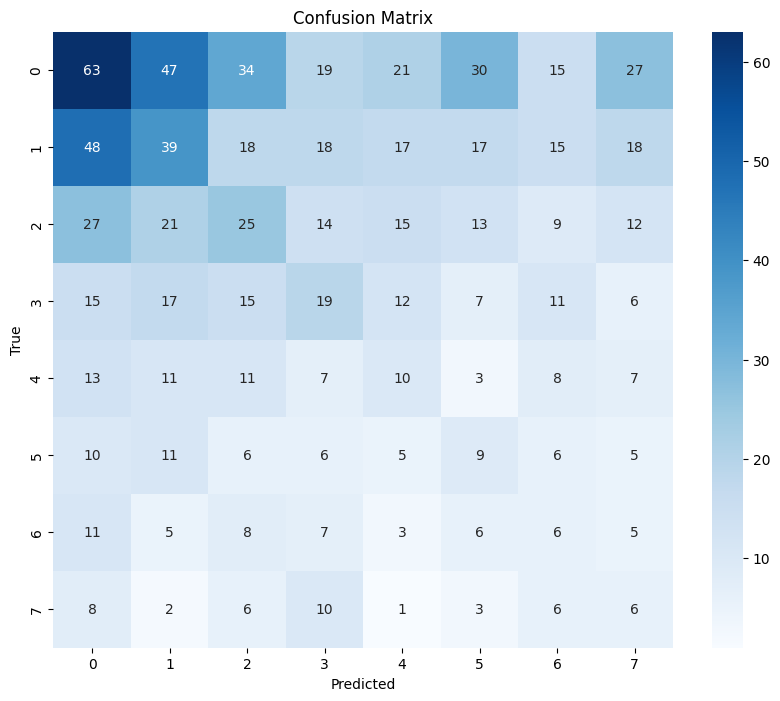

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
val_dataset = Refcocog(split='val', image_dir='/content/drive/MyDrive/visual-grounding/refcocog/images',
                          transform=transforms.Compose([transforms.ToTensor(), normalize]))
val_dataloader = data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False,
                                     num_workers=workers, pin_memory=True, drop_last=False)



predicted_labels,ground_truth_labels=inference(val_dataloader)
# Calculate the confusion matrix
confusion_matrix = confusion_matrix(ground_truth_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


When it comes to predicting the bbox index for visual grounding among region proposals, the use of a confusion matrix may not yield directly meaningful insights. This is because the bounding box indices do not possess a natural order or categorical labels. However, it is evident from the confusion matrix that the model has a significant margin of error.

# Visual grounding ( Bounding bbox prediction )

Now it's time to test the model to real (unseen images).

In this part, we developed code to perform visual grounding giving an image and a description

**0. Mount the drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

**1. Installations**

In [ ]:
!pip install ftfy regex tqdm
!pip install git+https://github.com/openai/CLIP.git
!pip install super-gradients==3.1.0
!pip install imutils
!pip install roboflow
!pip install pytube --upgrade

**2. Importing librairies**

In [ ]:
from super_gradients.training import models
import torch
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
import clip
from torch import nn
import matplotlib.pyplot as plt
import matplotlib.patches as patches

**3. Loading models**

In [ ]:
# Load YOLO-NAS
yolo_nas_l = models.get("yolo_nas_l", pretrained_weights="coco")

In [ ]:
# Load clip
device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, preprocess = clip.load("RN50", device=device, jit=False)

In [ ]:
# Init the fully connected model
fc_model = nn.Sequential(nn.Linear(1024, 1000), nn.ReLU(), nn.Linear(1000, 1024))

**4. Visual-Grounding model**


In [ ]:
# Preprocess the image
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.ToTensor(), normalize
])

In [ ]:
# FUnction return Region Proposals

def get_rpn(img_path):
  # Load and transform the image
  image = Image.open(img_path).convert('RGB')
  image = transform(image)
  #image = nn.functional.interpolate(image.unsqueeze(0),(224,224)).squeeze()

  # Yolo
  yolo_result = yolo_nas_l.predict(img_path)

  # Bboxes array
  prediction_objects = list(yolo_result._images_prediction_lst)[0]
  bboxes = prediction_objects.prediction.bboxes_xyxy

  # Load region proposals obtained with YOLO-NAS
  if len(bboxes)>0:
    # Getting all the bboxes
    bbox = torch.stack([torch.LongTensor(i) for i in bboxes])
    bbox_lbrt = torch.stack([bbox[:,0], bbox[:,1], bbox[:,2], bbox[:,3]], 1)

    # Store the region proposals together in one tensor by rescaling them to fixed size
    rpn_image = torch.FloatTensor(len(bboxes), 3, 224, 224).zero_()   # len(bboxes)

    for i in range(len(bboxes)): # len
        rpn_ = bbox_lbrt[i]
        rpn_image[i].copy_(torch.nn.functional.interpolate(image[:, rpn_[1]:rpn_[3], rpn_[0]:rpn_[2]].unsqueeze(0), (224, 224)).squeeze())

  return rpn_image, bboxes

In [ ]:
from torch.autograd.grad_mode import no_grad

def VisualGround(txt, img_path, clip_model, fc_model, device, checkpoint, transform):


  # Generationg region proposals using YOLO-NAS
  region_proposals, rpn_bboxes = get_rpn(img_path)
  region_proposals = region_proposals.to(device)
  region_proposals=region_proposals.unsqueeze(0)

  batch,r, c, h, w = region_proposals.size()

  # Image features
  img_features = clip_model.encode_image(region_proposals.view(r, c, h, w))
  norm = img_features.norm(p=2, dim=1, keepdim=True)
  img_features = img_features.div(norm).view(1, r, -1)

  # Loading Model Parameters
  #clip_model.load_state_dict(checkpoint['clip_model'])
  #fc_model.load_state_dict(checkpoint['fc_model'])

  # Preprocess the sentence
  caption = clip.tokenize(txt).to(device)

  # Encode the sentence features using the CLIP model
  sentence_features = clip_model.encode_text(caption)

  # Convert the sentence_features tensor to torch.float32
  sentence_features = sentence_features.to(torch.float32)

  # Pass the sentence features through the custom model
  with torch.no_grad():
    sentence_features = fc_model(sentence_features)
  sentence_features = sentence_features.unsqueeze(2)

  # Allocation to device
  img_features = img_features.to(device, dtype=torch.float32)
  sentence_features = sentence_features.to(device, dtype=torch.float32)

  # Product in latent space
  scores =  torch.bmm(img_features, sentence_features).squeeze()

  # Summary
  pred = torch.argmax(scores)
  scores[pred] = min(scores)
  pred_bbox = rpn_bboxes[pred].tolist()

  return pred_bbox

In [ ]:
# Display bbox prediction

def display_bbox(img_path, bbox):
  print('=> Plot image with bounding box around referred object')
  fig, ax = plt.subplots(1)
  im = plt.imread(img_path)
  ax.imshow(im)

  w, h = bbox[2] - bbox[0], bbox[3] - bbox[1]


  rect = patches.Rectangle((bbox[0], bbox[1]), w, h, fill = False, edgecolor = 'b')
  ax.add_patch(rect)
  plt.grid
  plt.tight_layout()
  plt.show()

In [ ]:
# Load the checkpoint
checkpoint = torch.load('/content/drive/MyDrive/visual-grounding/checkpoint.pth.tar', map_location='cpu')

In [ ]:
clip_model.load_state_dict(checkpoint['clip_model'])
fc_model.load_state_dict(checkpoint['fc_model'])

# Model Allocation to Device
fc_model.to(device)
clip_model.to(device)

In [ ]:
# Visual grounding
pred = VisualGround('a person with a cup', '/content/COCO_train2014_000000044827.jpg', clip_model, fc_model, device, checkpoint, transform)
display_bbox('/content/COCO_train2014_000000044827.jpg',  pred)